In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d, CubicSpline
from scipy.optimize import minimize


In [4]:
def linear_ode_ex_fitting_al_3compt(t, y, theta):
    """
    Three-compartment ODE system.
    """
    K = np.array([
        [-theta[0], theta[1], theta[2]],
        [theta[0], -theta[1], 0],
        [0, 0, -theta[2]],
    ])
    return K @ y

In [5]:
def spline_derivs(t, y):
    """
    Compute derivatives of observed data using cubic splines.
    """
    cs = CubicSpline(t, y)
    return cs.derivative()(t)

In [ ]:
def nl_ode_ls_deriv(fun, t_obs, y_obs, y_prime_obs, alpha, theta, n, dim, t_0, t_weights):
    """
    Compute the least-squares objective function with regularization.
    """
    # clamp value
    alpha = max(0, min(1, alpha))

    sol = solve_ivp(fun, [t_0, max(t_obs)], theta[-n:], t_eval=t_obs, args=(theta,), method='RK45')
    y_est = sol.y
    y_num = interp1d(sol.t, y_est, kind='cubic')(t_obs)

    # get derivation
    y_deriv_num = np.zeros_like(y_num)
    for i, t in enumerate(t_obs):
        y_deriv_num[:, i] = fun(t, y_num[:, i], theta)

    # ls components
    t_sum = np.sum(t_weights)
    ssd_f = np.sum(((y_num[dim, :] - y_obs) ** 2) @ t_weights) / t_sum
    ssd_df = np.sum(((y_deriv_num[dim, :] - y_prime_obs) ** 2) @ t_weights) / t_sum

    return (1 - alpha) * ssd_f + alpha * ssd_df

In [7]:
def pos_con(x, a):
    """
    POSITIVITY CONSTRAINT
    """
    pc = np.minimum(x, 0)
    pc = ((np.exp(-pc / a) + pc / a - 1) / (np.exp(1) - 2)) ** 2
    return pc


### Main

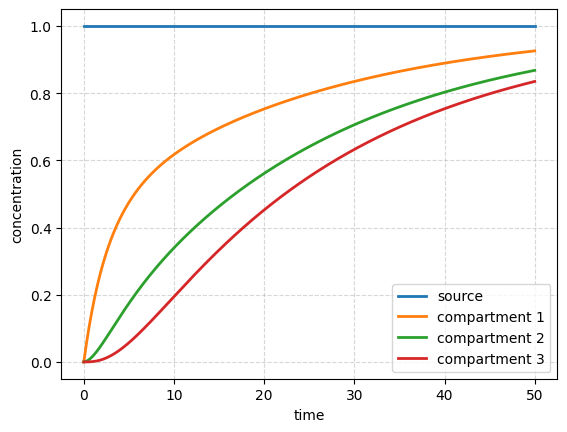

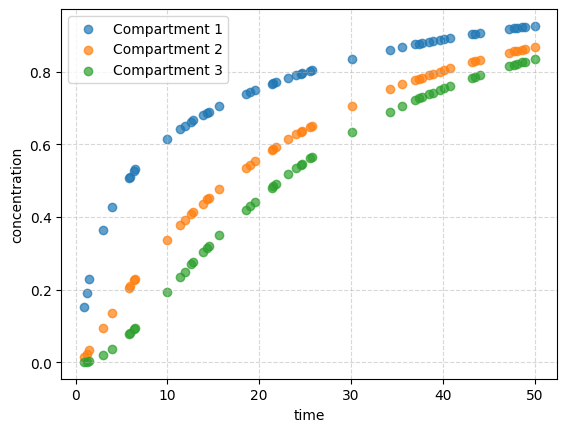

In [17]:
n_compartments = 3
source_concentration = 1
time_steps = 500
dt = 0.1
diffusion_rate = 0.2  # constant k_ij between all compartments

compartments = np.zeros(n_compartments)
source = source_concentration  # inf source
concentration = []

# stolen ken code
for t in range(time_steps):
    concentration.append(np.concatenate(([source], compartments.copy())))
    
    # source ----> first compartment
    flux_source = diffusion_rate * (source - compartments[0]) * dt
    compartments[0] += flux_source

    # diffusion between compartments
    fluxes = np.zeros(n_compartments)
    for i in range(n_compartments - 1):
        flux = diffusion_rate * (compartments[i] - compartments[i + 1]) * dt
        fluxes[i] -= flux
        fluxes[i + 1] += flux
    compartments += fluxes

concentration = np.array(concentration)
time = np.linspace(0, time_steps * dt, time_steps)

rng = np.random.default_rng(seed=1)
n_patients = 50

patient_times = rng.choice(time, size=n_patients, replace=False)
patient_data = []
for t_obs in patient_times:
    idx = np.abs(time - t_obs).argmin()
    snapshot = concentration[idx, 1:]  # exclude source conc
    patient_data.append(snapshot)

patient_data = np.array(patient_data)

# Plot the diffusion model
plt.plot(time, concentration[:, 0], label="source", linewidth=2)
for i in range(n_compartments):
    plt.plot(time, concentration[:, i + 1], label=f"compartment {i + 1}", linewidth=2)
plt.xlabel("time")
plt.ylabel("concentration")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Plot patient data
for i in range(n_compartments):
    plt.scatter(patient_times, patient_data[:, i], label=f"Compartment {i + 1}", alpha=0.7)
plt.xlabel("time")
plt.ylabel("concentration")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Exported values for integration with parameter fitting
t_obs = patient_times  # Observation times
y_obs = patient_data[:, 0]  # Observed data (example for first compartment)
sort_indices = np.argsort(t_obs)
t_obs = t_obs[sort_indices]
y_obs = y_obs[sort_indices]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90261D+03    |proj g|=  3.53154D+04


 This problem is unconstrained.



At iterate    1    f=  1.44269D+03    |proj g|=  1.69656D+04

At iterate    2    f=  1.42886D+03    |proj g|=  3.15739D+03

At iterate    3    f=  1.40812D+03    |proj g|=  6.28882D+03

At iterate    4    f=  1.32482D+03    |proj g|=  2.53815D+04

At iterate    5    f=  1.07887D+03    |proj g|=  5.02741D+04

At iterate    6    f=  3.31611D+02    |proj g|=  3.05249D+04

At iterate    7    f=  6.81768D+01    |proj g|=  5.46082D+03

At iterate    8    f=  6.76968D+01    |proj g|=  5.71145D+03

At iterate    9    f=  6.26458D+01    |proj g|=  5.10057D+03

At iterate   10    f=  6.10363D+01    |proj g|=  4.95400D+03

At iterate   11    f=  5.67878D+01    |proj g|=  4.66999D+03

At iterate   12    f=  4.50752D+01    |proj g|=  3.86755D+03

At iterate   13    f=  2.76231D+01    |proj g|=  2.18227D+03

At iterate   14    f=  1.17842D+01    |proj g|=  1.05442D+03

At iterate   15    f=  4.28620D+00    |proj g|=  5.23055D+02

At iterate   16    f=  1.10519D+00    |proj g|=  2.14986D+02

At iter

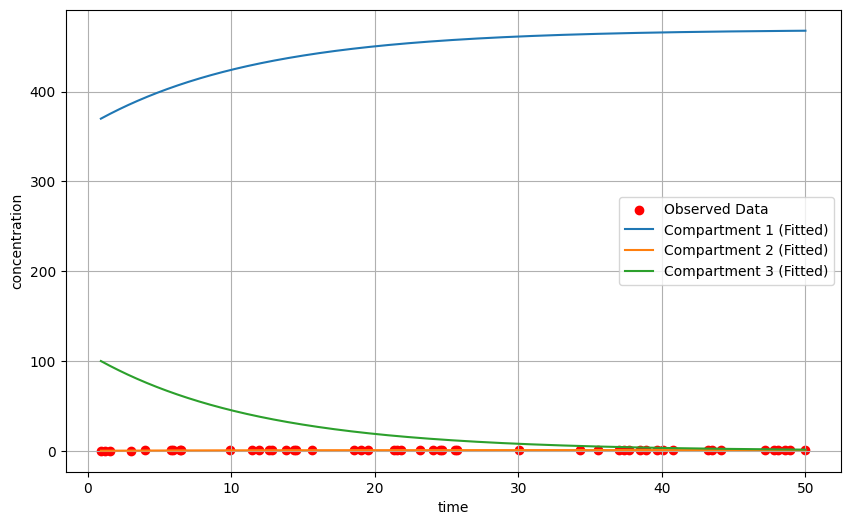

In [19]:
#  print(t_obs)
y_prime_obs = spline_derivs(t_obs, y_obs)

n = 3  # comparments
alpha = 0.9
R = 1e3
t_weights = np.diff(np.concatenate(([t_obs[0]], t_obs)))
t_0 = t_obs[0]

dim = [1] 
C2_0 = y_obs[0]
hydro_mag = 1e2
C3_0 = hydro_mag

# initial parameters
C1_0 = 370 - C2_0
theta_0 = [0.5, 0.5, 1 / hydro_mag, C1_0, C2_0, C3_0]

def ssd(theta):
    return nl_ode_ls_deriv(
        linear_ode_ex_fitting_al_3compt, t_obs, y_obs, y_prime_obs, alpha, theta, n, dim, t_0, t_weights
    ) + R * (np.sum(pos_con(theta[:3], 0.1)) + np.sum(pos_con(theta[3:], 10)))

# optimization
result = minimize(ssd, theta_0, method='L-BFGS-B', options={'disp': True, 'maxiter': 2000})
theta_fitted = result.x
t_span = [min(t_obs), max(t_obs)]
sol = solve_ivp(linear_ode_ex_fitting_al_3compt, t_span, theta_fitted[-n:], t_eval=np.linspace(*t_span, 1000), args=(theta_fitted,))

plt.figure(figsize=(10, 6))
plt.scatter(t_obs, y_obs, color='red', label='Observed Data')
for i in range(n):
    plt.plot(sol.t, sol.y[i], label=f"Compartment {i + 1} (Fitted)")
plt.xlabel("time")
plt.ylabel("concentration")
plt.legend()
plt.grid()
plt.show()
